In [1]:
%load_ext autoreload
%autoreload 2
%run A_simple_net.ipynb

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/__init__.py:53: UserWarning:Unable to install NEST extensions. Certain models may not be available.


Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

numpy     : 1.19.2
matplotlib: 3.3.2
pyNN      : 0.9.5
neo       : 0.8.0
nixio     : 1.5.0b6
pandas    : 0.25.3

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-56-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: inv-ope-de06

Git hash: 19c9ce9dd5fc286086d33adb94a47085bdca80f0

Git repo: https://github.com/SpikeAI/2020-11_brainhack_Project7

Git branch: main



In [2]:
%mkdir -p outputs

In [3]:
%mkdir -p Results/20201204/

# scanning over single parameters

## initializing parameters

In [4]:
date = '2020-12-04'
tag = date + '_scan_' + simulator

In [5]:
buildCPUTime, simCPUTime, writeCPUTime = run(verbose=True)

/usr/lib/python3.8/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.
2020-12-04 16:27:18,739 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:27:18,741 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


0 Creating cell populations...
0 Initialising membrane potential to random values...
0 Connecting populations...
0 Setting up recording...0%                                                                                                                                                                                                                                           
0 Running simulation...
0 Writing data to file...

--- Vogels-Abbott Network Simulation ---
Nodes                  : 1
Number of Neurons      : 1000
Excitatory conductance : 4 nS
Inhibitory conductance : 51 nS
Excitatory rate        : 0.715 Hz
Inhibitory rate        : 0.73 Hz
Build time             : 1932.67 ms
Simulation time        : 2367.59 ms
Writing time           : 213.14 ms


## Running Model and Loading Results

In [6]:
import os
import pandas as pd
verbose = True
def scan(variable, values, tag=tag, verbose=verbose):
    filename = f'outputs/{tag}_{variable}.json'
    try:
        df = pd.read_json(filename)
        print('Loaded file')
    except:
        df = pd.DataFrame([], columns=[variable, 'buildCPUTime', 'simCPUTime', 'writeCPUTime'])
        for i, value in enumerate(values):
            if verbose: print(f'{variable=}---{value=}')
            args = {}
            args[variable] = value
            buildCPUTime, simCPUTime, writeCPUTime = run(**args)
            df.loc[i]= {variable: value, 'buildCPUTime':buildCPUTime, 'simCPUTime':simCPUTime, 'writeCPUTime':writeCPUTime}
        df.to_json(filename)
    return df

In [7]:
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression
def plot(df, do_intercept=False):
    variable = df.columns[0]
    fig, ax = plt.subplots(figsize=(8,8))
    
    for regressor, color in zip(['buildCPUTime', 'simCPUTime', 'writeCPUTime'],
                                ['r', 'g', 'b']):

        import patsy
        if do_intercept:
            y, X = patsy.dmatrices(f'{regressor} ~ {variable}', data=df, return_type='dataframe')
        else:
            y, X = patsy.dmatrices(f'{regressor} ~ 0 + {variable}', data=df, return_type='dataframe')

        import statsmodels.api as sm
        fit = sm.OLS(y, X).fit()
        print(fit.summary())

        if do_intercept: intercept = fit.params.Intercept
        slope = fit.params[variable]

        values = np.array(df[variable])
        if do_intercept:
            ax.plot(values, intercept + slope*values, c=color, lw=1)
            df.plot(x=variable, y=regressor, c=color, lw=2, ls='-.', ax=ax, label=f"{regressor}={intercept:.3f} + {slope:.3f}*{variable}")
        else:
            ax.plot(values, slope*values, c=color, lw=1)
            df.plot(x=variable, y=regressor, c=color, lw=2, ls='-.', ax=ax, label=f"{regressor}={slope:.3f}*{variable}")

    ax.set_xlim(0)
    ax.set_ylabel('Time (ms)')
    ax.set_ylim(0)
    ax.legend()
    return fig, ax

## plot as a function of neuron numbers

In [8]:
import numpy as np
N_pops = np.array([int(k)**2 for k in np.linspace(8**2, 45**2, 14, endpoint=True)**.5])
N_pops

array([  64,  196,  361,  484,  625,  784,  961, 1089, 1225, 1369, 1521,
       1681, 1849, 2025])

In [9]:
results_pop = scan('N_pop', N_pops)

Loaded file


/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14


                                 OLS Regression Results                                
Dep. Variable:           buildCPUTime   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              5666.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):                    1.50e-18
Time:                        16:27:23   Log-Likelihood:                         -66.297
No. Observations:                  14   AIC:                                      134.6
Df Residuals:                      13   BIC:                                      135.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

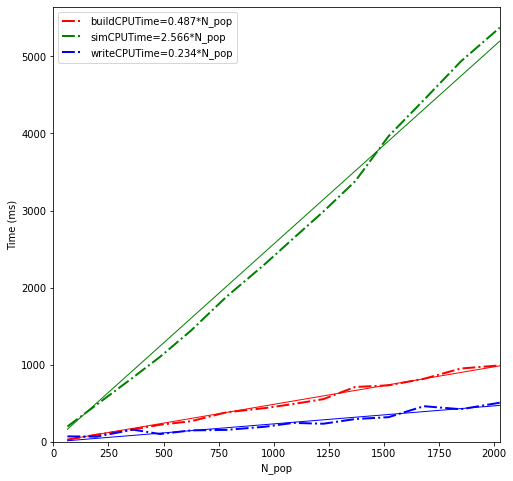

In [10]:
fig, ax = plot(results_pop)

In [11]:
fig.savefig(tag + '_N_pop.png')

## plot as a function of simtime

In [12]:
simtimes = np.linspace(500, 3000, 15, endpoint=True)
simtimes

array([ 500.        ,  678.57142857,  857.14285714, 1035.71428571,
       1214.28571429, 1392.85714286, 1571.42857143, 1750.        ,
       1928.57142857, 2107.14285714, 2285.71428571, 2464.28571429,
       2642.85714286, 2821.42857143, 3000.        ])

In [13]:
results_simtime = scan('simtime', simtimes)

Loaded file


                            OLS Regression Results                            
Dep. Variable:           buildCPUTime   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.140
Date:                Fri, 04 Dec 2020   Prob (F-statistic):              0.305
Time:                        16:27:24   Log-Likelihood:                -62.102
No. Observations:                  15   AIC:                             128.2
Df Residuals:                      13   BIC:                             129.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    493.2684     10.450     47.204      0.0

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15


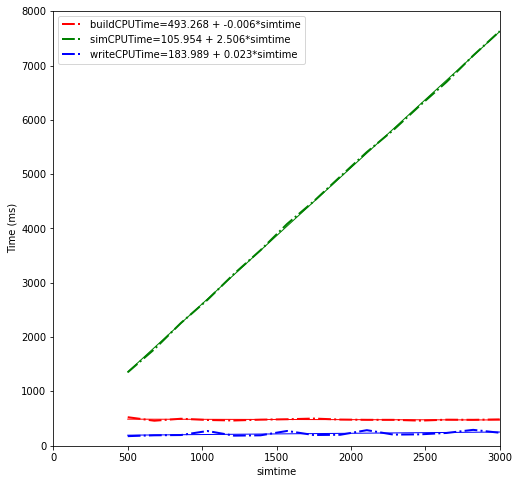

In [14]:
fig, ax = plot(results_simtime, do_intercept=True)      

In [15]:
fig.savefig(tag + '_simtime.png')

# scanning over two parameters

## Setting-up model and initializing parameters

In [16]:
tag = date + '_scan-2D_' + simulator

## Running Model and Loading Results

In [17]:
variables = ['N_pop', 'simtime']
filename = f'outputs/{tag}'
for variable in variables: filename +=  '_' + variable
filename += '.json'

In [18]:
import os
import time
import pandas as pd
verbose = True
def scan(variables, values, tag=tag, verbose=verbose):
    filename = f'outputs/{tag}'
    for variable in variables: filename +=  '_' + variable
    filename += '.json'
    try:
        df = pd.read_json(filename)
        print('Loaded file')
    except:
        df = pd.DataFrame([], columns=variables + ['buildCPUTime', 'simCPUTime', 'writeCPUTime'])
        for i, values_ in enumerate(values):
            if verbose: print(f'{variable=}---{values_=}')
            args = {}
            for variable, value in zip(variables, values_):
                args[variable] = value
            buildCPUTime, simCPUTime, writeCPUTime = run(**args)
            df.loc[i]= dict(zip(variables + ['buildCPUTime', 'simCPUTime', 'writeCPUTime'], 
                                list(values_) + [buildCPUTime, simCPUTime, writeCPUTime]))

        df.to_json(filename)
        
    return df

## Running time as a function of neuron numbers and simtime

In [19]:
import numpy as np

In [20]:
N_trials = 200
N_pops = [int(k)**2 for k in np.linspace(15, 60, N_trials, endpoint=True)]
simtimes = np.linspace(200, 3000, N_trials, endpoint=True)

In [21]:
np.random.seed(42)
np.random.shuffle(N_pops)
np.random.shuffle(simtimes)
values = zip(N_pops, simtimes)

In [22]:
results = scan(variables=variables, values=values)
results

Loaded file


,N_pop,simtime,buildCPUTime,simCPUTime,writeCPUTime
0,1296,2676.381910,599.036455,8520.785809,326.922178
1,324,664.321608,143.315792,512.142181,98.772764
2,441,1902.512563,178.263664,1931.942940,130.185366
3,2500,2732.663317,1222.176790,17846.006632,796.371222
4,1849,1635.175879,866.493940,8081.131458,480.911016
...,...,...,...,...,...
195,1444,2606.030151,1030.984640,11107.993126,378.175497
196,324,931.658291,201.613426,747.238398,99.138975
197,1225,2015.075377,843.507290,6943.225384,258.156776
198,3025,1958.793970,2219.290733,17289.569378,917.819977


## analysis

In [23]:
results_ext = results.copy()
results_ext['simtime_N_pop'] = results_ext['simtime'] * results_ext['N_pop']
results_ext

,N_pop,simtime,buildCPUTime,simCPUTime,writeCPUTime,simtime_N_pop
0,1296,2676.381910,599.036455,8520.785809,326.922178,3.468591e+06
1,324,664.321608,143.315792,512.142181,98.772764,2.152402e+05
2,441,1902.512563,178.263664,1931.942940,130.185366,8.390080e+05
3,2500,2732.663317,1222.176790,17846.006632,796.371222,6.831658e+06
4,1849,1635.175879,866.493940,8081.131458,480.911016,3.023440e+06
...,...,...,...,...,...,...
195,1444,2606.030151,1030.984640,11107.993126,378.175497,3.763108e+06
196,324,931.658291,201.613426,747.238398,99.138975,3.018573e+05
197,1225,2015.075377,843.507290,6943.225384,258.156776,2.468467e+06
198,3025,1958.793970,2219.290733,17289.569378,917.819977,5.925352e+06


In [24]:
variables_ext = ['N_pop', 'simtime_N_pop']
X = results_ext[variables_ext].values.reshape(-1, len(variables_ext))


https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python

See https://patsy.readthedocs.io/en/latest/quickstart.html

In [25]:
import patsy
import statsmodels.api as sm

for regressor in ['buildCPUTime', 'simCPUTime', 'writeCPUTime']:
    y = results_ext[regressor].values
    #print(variables_ext, X.shape, y.shape)
    y, X = patsy.dmatrices(f'{regressor} ~ 0 + N_pop + simtime_N_pop', data=results_ext, return_type='dataframe')

    fit = sm.OLS(y, X).fit()
    fit.summary()

    print(f'{regressor} (ms) = {fit.params[0]:.3f} * N_pop + {fit.params[1]*1000:.3f} * simtime (ms) * N_pop/1000')

buildCPUTime (ms) = 0.583 * N_pop + 0.016 * simtime (ms) * N_pop/1000
simCPUTime (ms) = -0.007 * N_pop + 2.841 * simtime (ms) * N_pop/1000
writeCPUTime (ms) = 0.202 * N_pop + 0.035 * simtime (ms) * N_pop/1000
